# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
df = pd.read_csv("data/semiyearly_chosen_columns.csv").iloc[:,1:]
df

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc_x,...,Total alarms,n_conflict_total,Average of centy,Average of centx,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,3733.04131,1085.97565,0.36920,0.08320,0.18000,...,2.16667,NaN,3.54944,46.54467,NaN,0.35100,7,False,-0.01820,0
1,2017-07-01,Lughaye,70268.22000,14053.64400,5334.76326,4220.30929,1114.45397,0.37960,0.07930,0.36000,...,2.66667,1.00000,10.64738,43.57812,NaN,0.16900,7,False,-0.21060,58
2,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,3652.89311,1205.26930,0.34060,0.08450,0.37000,...,2.33333,2.50000,8.46016,46.66129,NaN,0.20280,7,False,-0.13780,23
3,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,7366.95641,1306.19795,0.43160,0.06500,0.21000,...,7.83333,1.50000,3.79293,42.69760,NaN,0.39260,7,False,-0.03900,59
4,2017-07-01,Burtinle,112734.27000,22546.85400,10200.19675,8500.16396,1700.03279,0.45240,0.07540,0.22000,...,3.66667,NaN,7.80220,48.39912,NaN,0.37960,7,False,-0.07280,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,2021-07-01,Jariiban,NaN,32671.60000,10890.00000,NaN,1430.00000,0.33332,0.04377,0.19000,...,2.16667,NaN,7.16378,48.99860,0.34857,NaN,7,NaN,NaN,50
658,2021-07-01,Caluula,NaN,16168.60000,5560.00000,NaN,870.00000,0.34388,0.05381,0.16000,...,3.16667,1.00000,11.66822,50.79402,0.35925,NaN,7,NaN,NaN,28
659,2021-07-01,Qoryooley,NaN,25309.00087,11420.00000,NaN,2160.00000,0.45122,0.08535,0.08000,...,6.16667,3.50000,1.93456,44.44943,0.45939,NaN,7,NaN,NaN,65
660,2021-07-01,Baki,NaN,11187.80000,3470.00000,NaN,640.00000,0.31016,0.05721,0.37000,...,0.66667,1.00000,10.28566,43.73210,0.22769,NaN,7,NaN,NaN,7


# Fix MAM

In [3]:
df.MAM = df.GAM - df.SAM

# NOT REQUIRED
Fix total_population

In [4]:
df.date = pd.to_datetime(df.date)
id_columns = ["date","district","total population"]

In [5]:
df[id_columns].iloc[-73:]

,date,district,total population
589,2021-07-01,Baidoa,NaN
590,2021-07-01,Adan Yabaal,NaN
591,2021-07-01,Ceel Waaq,NaN
592,2021-07-01,Wanla Weyn,NaN
593,2021-07-01,Zeylac,NaN
...,...,...,...
657,2021-07-01,Jariiban,NaN
658,2021-07-01,Caluula,NaN
659,2021-07-01,Qoryooley,NaN
660,2021-07-01,Baki,NaN


### Show the population distribution for a randomly selected district over time

In [6]:
district_number = np.random.randint(0,73)
df[df.district==df.district[0]][id_columns]

,date,district,total population
0,2017-07-01,Adan Yabaal,65262.96000
127,2018-01-01,Adan Yabaal,65262.96000
182,2018-07-01,Adan Yabaal,37859.15495
234,2019-01-01,Adan Yabaal,37859.15495
360,2019-07-01,Adan Yabaal,37859.15495
430,2020-01-01,Adan Yabaal,35879.12501
448,2020-07-01,Adan Yabaal,35878.00000
535,2021-01-01,Adan Yabaal,35879.00000
590,2021-07-01,Adan Yabaal,NaN


### Carry out an LOCF time series imputation for total population

In [7]:
for i in range(74):
    # retrieve district name
    district = df.district[i]
    # retrieve index of the district for 2021-07-01
    index = df[(df.date=="2021-07-01")&(df.district==district)].index
    try:
        # set its value to 2021-01-01
        value = df[(df.date=="2021-01-01")&(df.district==district)]['total population'].values[0]
    except:
        # if that value does not exist, just use its previous recorded population value
        value = df[df.district==district]['total population'].values[-2]

    # change nans to the previous population value which is now carried forward
    df.loc[index,'total population'] = value

### Check 2021 `total_population` values

In [8]:
df.iloc[-73:]

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc_x,...,Total alarms,n_conflict_total,Average of centy,Average of centx,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
589,2021-07-01,Baidoa,515337.00000,124149.80000,56660.00000,45680.00000,10980.00000,0.45638,0.08844,0.17000,...,7.83333,12.00000,3.26636,43.63929,0.48097,NaN,7,NaN,NaN,6
590,2021-07-01,Adan Yabaal,35879.00000,17190.00000,4930.00000,4220.00000,710.00000,0.28679,0.04130,0.10000,...,1.33333,1.50000,3.54944,46.54467,0.27735,NaN,7,NaN,NaN,0
591,2021-07-01,Ceel Waaq,39782.00000,17519.20000,6210.00000,5290.00000,920.00000,0.35447,0.05251,0.15000,...,6.50000,1.25000,2.67898,41.44526,0.26650,NaN,7,NaN,NaN,34
592,2021-07-01,Wanla Weyn,66459.00000,63909.40000,28650.00000,22910.00000,5740.00000,0.44829,0.08981,0.07000,...,4.66667,2.40000,2.79164,44.90647,0.47141,NaN,7,NaN,NaN,72
593,2021-07-01,Zeylac,72825.00000,11246.40000,2690.00000,2350.00000,340.00000,0.23919,0.03023,0.15000,...,1.16667,1.00000,10.89293,43.16827,0.18538,NaN,7,NaN,NaN,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,2021-07-01,Jariiban,74373.00000,32671.60000,10890.00000,9460.00000,1430.00000,0.33332,0.04377,0.19000,...,2.16667,NaN,7.16378,48.99860,0.34857,NaN,7,NaN,NaN,50
658,2021-07-01,Caluula,51766.00000,16168.60000,5560.00000,4690.00000,870.00000,0.34388,0.05381,0.16000,...,3.16667,1.00000,11.66822,50.79402,0.35925,NaN,7,NaN,NaN,28
659,2021-07-01,Qoryooley,207773.00000,25309.00087,11420.00000,9260.00000,2160.00000,0.45122,0.08535,0.08000,...,6.16667,3.50000,1.93456,44.44943,0.45939,NaN,7,NaN,NaN,65
660,2021-07-01,Baki,99157.00000,11187.80000,3470.00000,2830.00000,640.00000,0.31016,0.05721,0.37000,...,0.66667,1.00000,10.28566,43.73210,0.22769,NaN,7,NaN,NaN,7


In [9]:
count_missing_district(df)

,date,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc_x,rainfall,...,Total alarms,n_conflict_total,Average of centy,Average of centx,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
district,,,,,,,,,,,,,,,,,,,,,
Adan Yabaal,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,1,1,0,1,1,0
Afgooye,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
Afmadow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
Baardheere,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
Badhaadhe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wanla Weyn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
Xarardheere,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,1,1,0
Xudun,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,1,1,0,1,1,0


# Fix Conflicts

In [10]:
id_columns = ['date', 'district', 'n_conflict_total']

### Test spline interpolation with a degree of 3

In [11]:
district_number = np.random.randint(0,73)
name = df.district[district_number]
data = df[df.district==name]['n_conflict_total']
data_spline = data.interpolate("spline", order=3)
print(f"Original conflict data from {name}:\n{data}")
print(f"Spline interpolated conflict data from {name}:\n{data_spline}")

Original conflict data from Baardheere:
70    4.00000
110   7.33333
159   2.80000
290   3.80000
366   2.50000
428   2.33333
458   2.20000
578   3.00000
598   2.80000
Name: n_conflict_total, dtype: float64
Spline interpolated conflict data from Baardheere:
70    4.00000
110   7.33333
159   2.80000
290   3.80000
366   2.50000
428   2.33333
458   2.20000
578   3.00000
598   2.80000
Name: n_conflict_total, dtype: float64


### Plot original conflict data per district

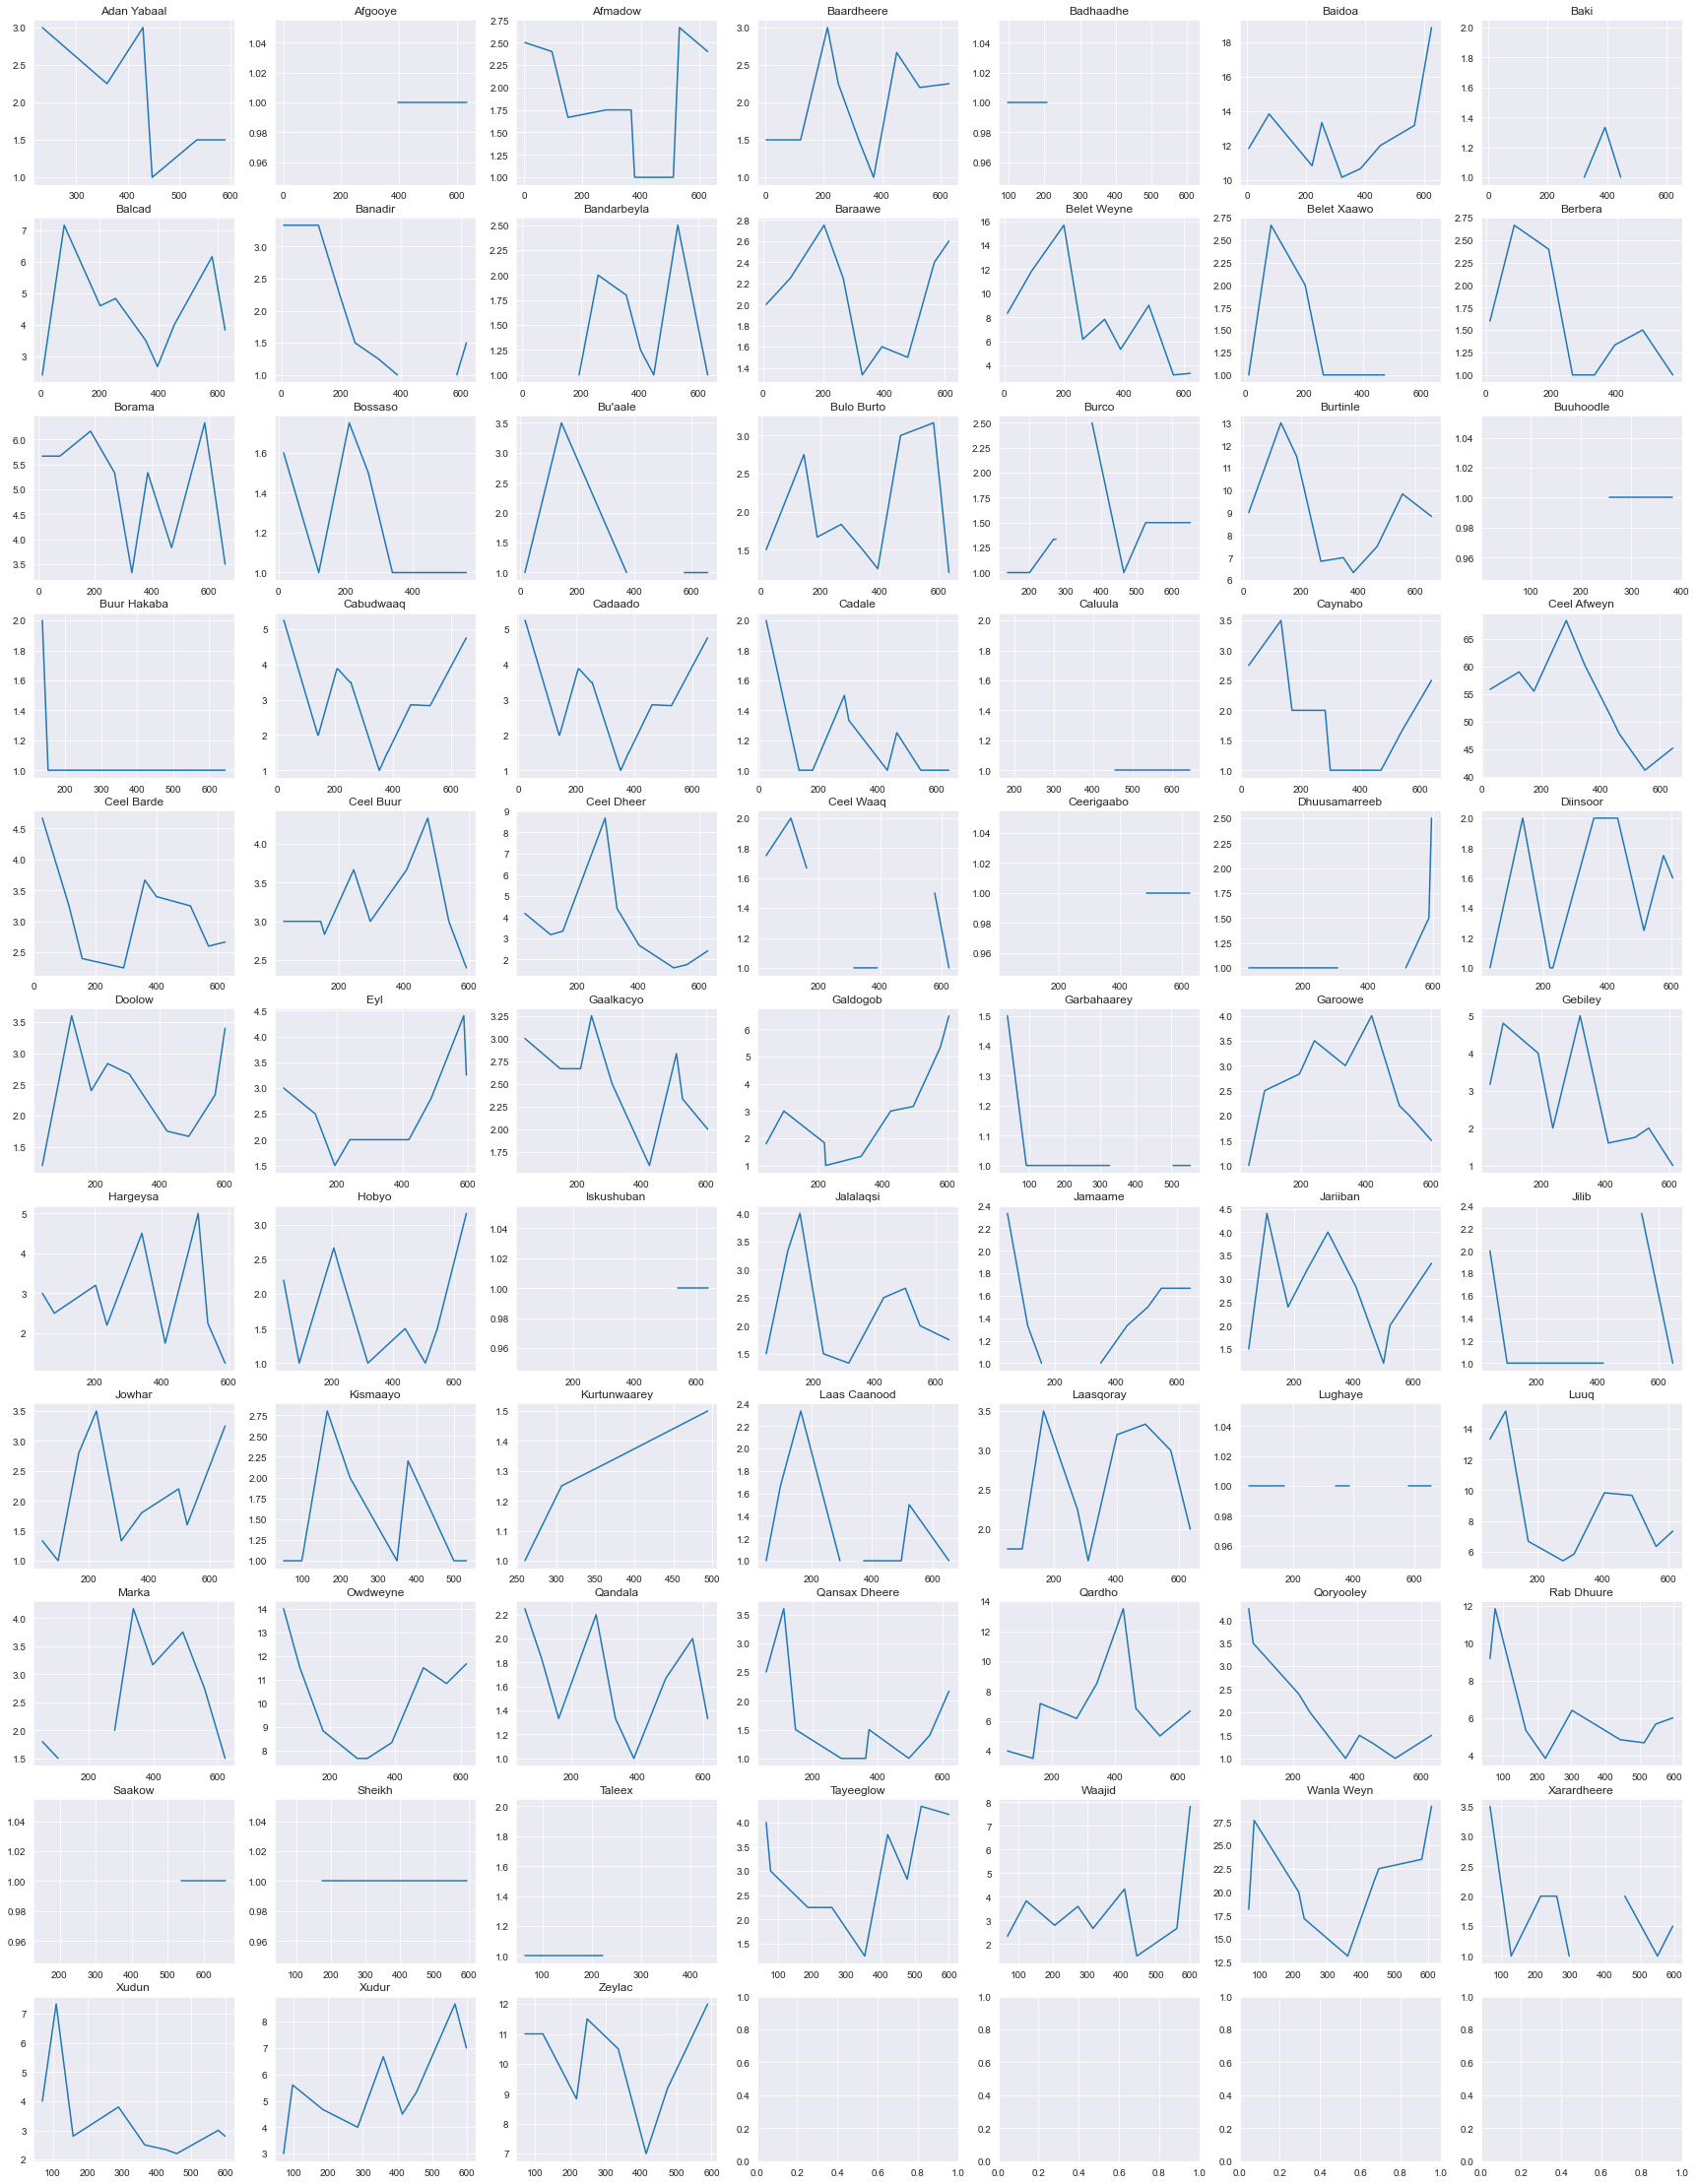

In [12]:
districts = np.sort(df.district.unique())
fig, ax = plt.subplots(nrows=11, ncols=7, figsize=(30,40))
axs = ax.ravel()
data = np.arange(0,73)

for ax, d in zip(axs.ravel(), data):
    ax.plot(df[df.district==df.district[d]]["n_conflict_total"])
    ax.set_title(districts[d])

### Check imputations for randomly selected districts

In [13]:
district_number = np.random.randint(0,73)
name = df.district[district_number]
data = df[df.district==name]['n_conflict_total']
data_spline = data.interpolate("spline", order=1).bfill()
print(f"Original conflict data from {name}:\n{data}")
print(f"Spline interpolated conflict data from {name}:\n{data_spline}")

Original conflict data from Saakow:
18        NaN
138   1.00000
197   1.00000
200   1.00000
267   1.33333
274   1.33333
300       NaN
301       NaN
375   2.50000
464   1.00000
525   1.50000
650   1.50000
Name: n_conflict_total, dtype: float64
Spline interpolated conflict data from Saakow:
18    1.00000
138   1.00000
197   1.00000
200   1.00000
267   1.33333
274   1.33333
300   1.30747
301   1.30849
375   2.50000
464   1.00000
525   1.50000
650   1.50000
Name: n_conflict_total, dtype: float64


### Interpolate the data with a degree of 3

In [25]:
for i in range(74):
    # retrieve district name
    name = df.district[i]

    # retrieve conflict data
    data = df[df.district==name]['n_conflict_total']

    # retrieve indices of the missing values
    index = data[data.isna()].index.tolist()

    # interpolate and fill any missing values with a reasonable estimate
    data_spline = data.interpolate("spline", order=3).bfill()

    # retrieve interpolated values at the required indices
    conflict = data_spline[index].values.tolist()

    df.loc[index,'n_conflict_total'] = conflict


# Plot the imputed total_conflict per district

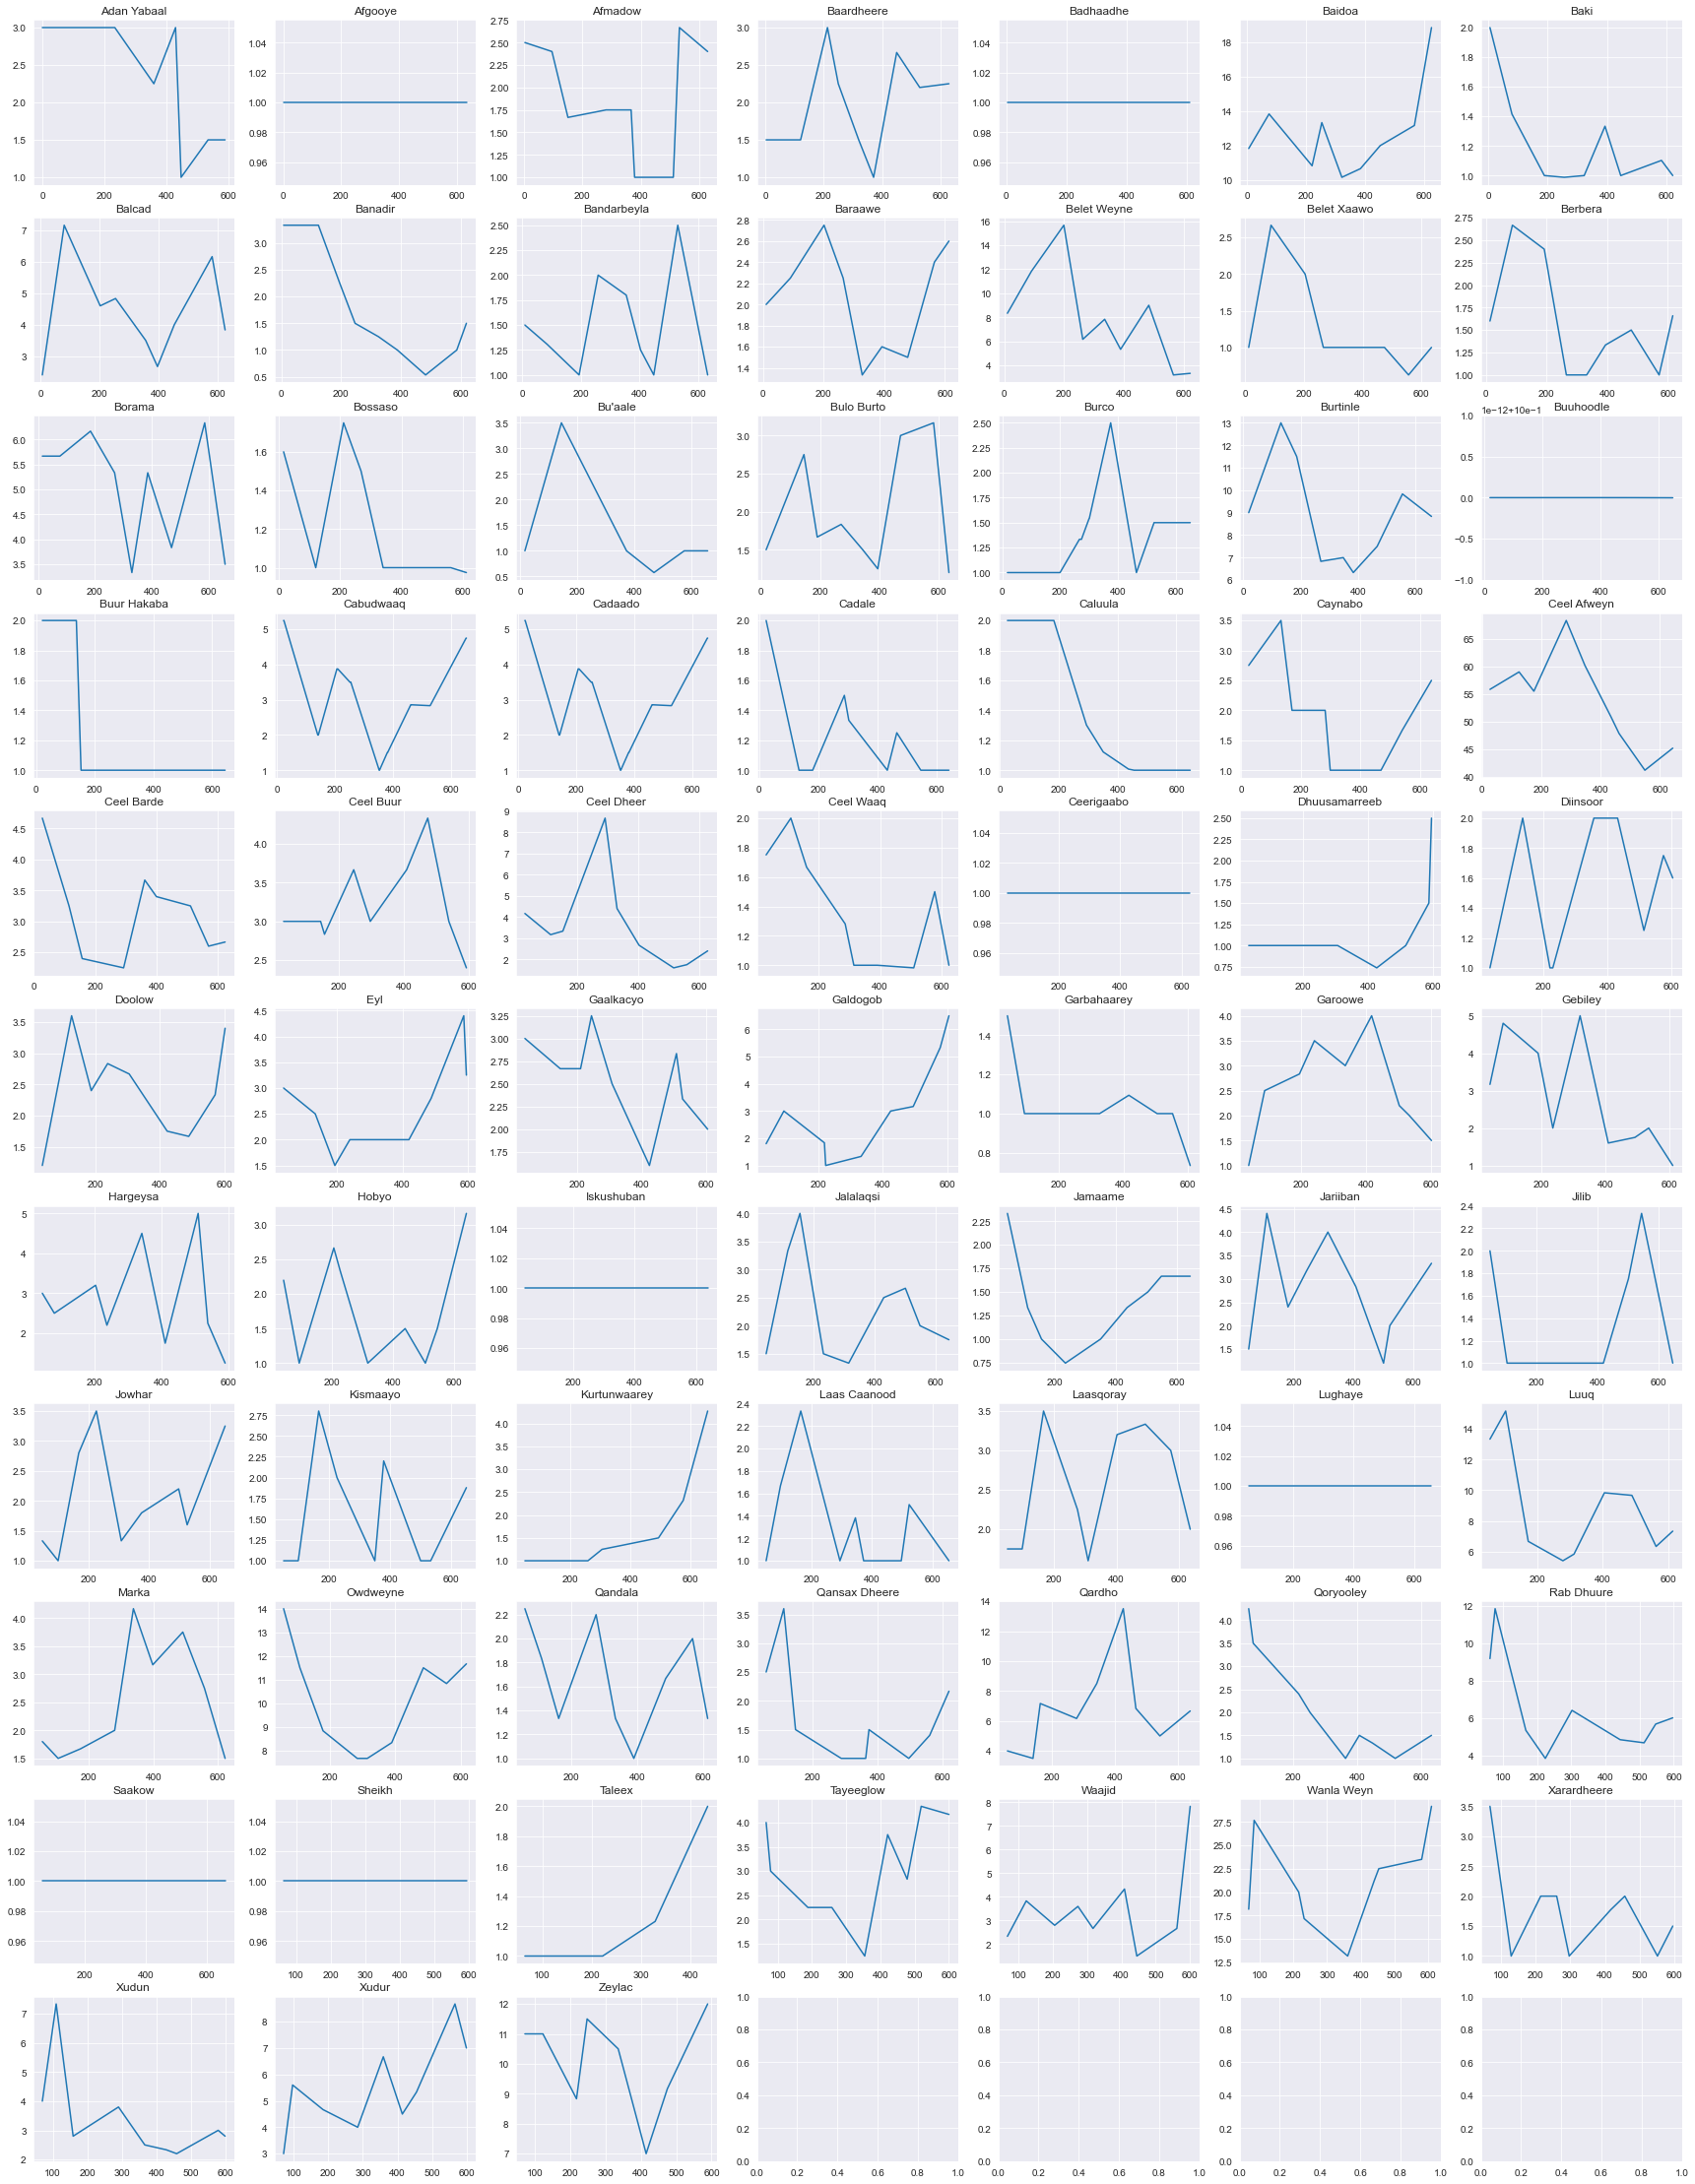

In [26]:
districts = np.sort(df.district.unique())
fig, ax = plt.subplots(nrows=11, ncols=7, figsize=(30,40))
axs = ax.ravel()
data = np.arange(0,73)

for ax, d in zip(axs.ravel(), data):
    ax.plot(df[df.district==df.district[d]]["n_conflict_total"])
    ax.set_title(districts[d])

# Fix Price of Water

In [27]:
X = df.select_dtypes(exclude=["object","category"]).iloc[:,1:]
X.isna().sum().sort_values(ascending=False)

increase_numeric         73
next_prevalence          73
prevalence_6lag          73
ndvi_score                7
phase3plus_perc_x         2
total population          0
Total alarms              0
month                     0
Average of centx          0
Average of centy          0
n_conflict_total          0
Price of water            0
Under-Five Population     0
rainfall                  0
SAM Prevalence            0
GAM Prevalence            0
SAM                       0
MAM                       0
GAM                       0
district_encoded          0
dtype: int64

In [28]:
mice_imputer = IterativeImputer(n_nearest_features=5, max_iter=100).fit_transform(X)
df_imputed = pd.DataFrame(mice_imputer, columns=X.columns)

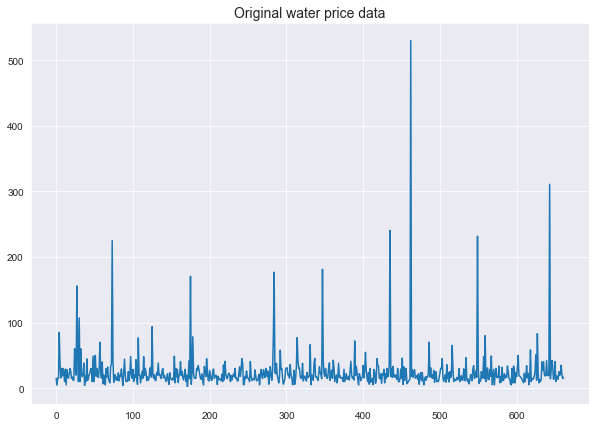

In [29]:
plt.figure(figsize=(10,7))
plt.title("Original water price data", size=14)
df["Price of water"].plot();

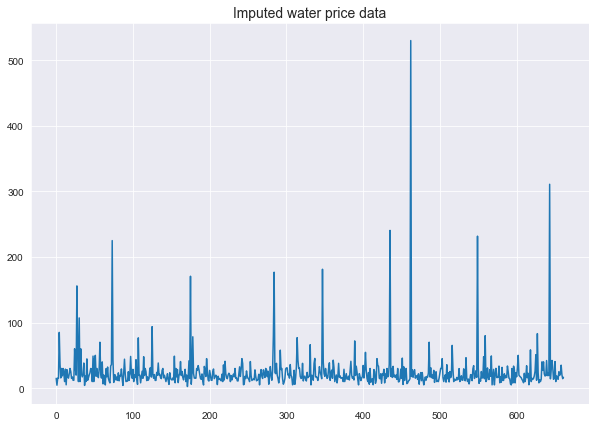

In [30]:
plt.figure(figsize=(10,7))
plt.title("Imputed water price data", size=14)
df_imputed["Price of water"].plot();

In [31]:
df["Price of water"] = df_imputed["Price of water"]

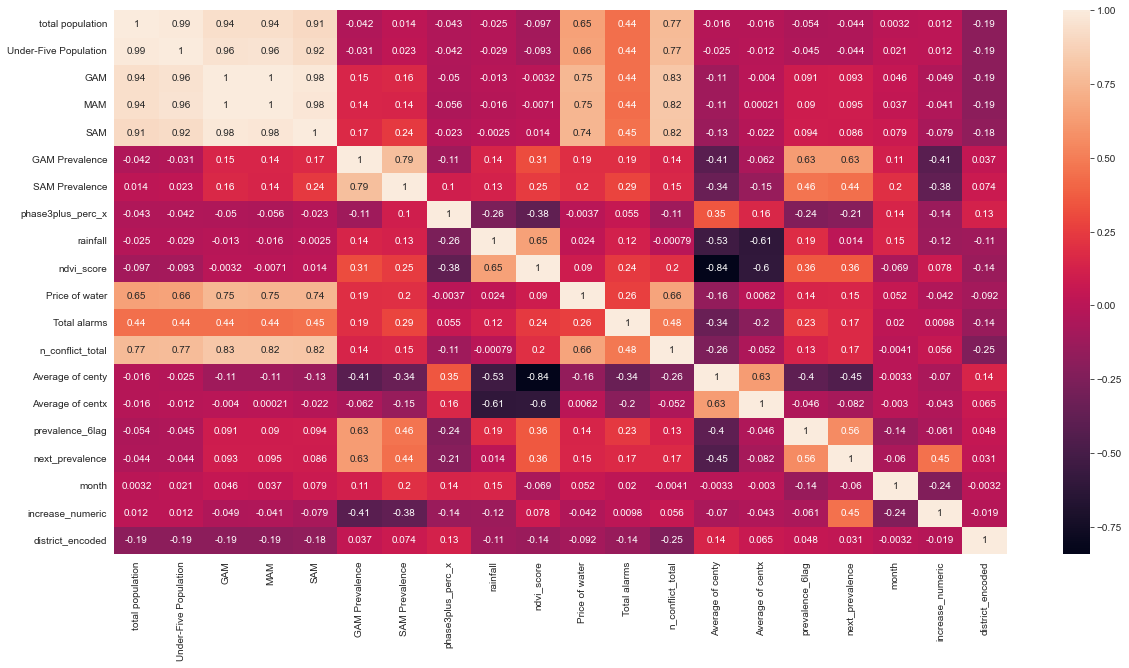

In [32]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,);

In [33]:
#df.to_csv("mixImputed_data.csv")